# Step 6: Post-Scoring Packaging
Backup results, generate reports, produce scored PDFs, and collect samples for sharing. Run after completing scoring and checks.

In [48]:
passingMark = 15

In [49]:
from grading_utils import setup_paths, create_directories

prefix = "VTC Test"
paths = setup_paths(prefix, "sample")

# Extract commonly used paths
pdf_file = paths["pdf_file"]
name_list_file = paths["name_list_file"]
base_path = paths["base_path"]
base_path_images = paths["base_path_images"]
base_path_annotations = paths["base_path_annotations"]
base_path_questions = paths["base_path_questions"]
base_path_marked_images = paths["base_path_marked_images"]
base_path_marked_pdfs = paths["base_path_marked_pdfs"]
base_path_marked_scripts = paths["base_path_marked_scripts"]

# Create all necessary directories
create_directories(paths)

## Backup grading result
Remove version history, before you backup.

In [50]:
import os
for path, currentDirectory, files in os.walk(base_path_questions):
    for file in files:
        if file.startswith("control-") or file.startswith("mark-"):
            os.remove(os.path.join(path, file))

Zip the website.

In [51]:
import shutil
shutil.make_archive(base_path,"zip",base_path)

'/workspaces/gemini-handwriting-grader/marking_form/VTC Test.zip'

# Generate Score Report

Check the ID and Name pages to verify the values before generate the marksheet.

In [52]:
import os
import json
import pandas as pd

from grading_utils import build_student_id_mapping

# Load name list as authoritative source for student names
name_list_df = pd.read_excel(name_list_file, sheet_name="Name List")
id_col = next((col for col in name_list_df.columns if col.lower() == "id"), None)
name_col = next((col for col in name_list_df.columns if col.lower() in ["name", "student name", "student_name"]), None)
if id_col is None or name_col is None:
    raise ValueError("Name list must contain ID and NAME columns.")
name_map = (
    name_list_df.assign(**{id_col: name_list_df[id_col].astype(str)})
    .set_index(id_col)[name_col]
    .astype(str)
    .to_dict()
)

# Build student ID mapping using utility function
pageToStudentId, numberOfPage, getStudentId = build_student_id_mapping(
    base_path_questions, base_path_annotations
)

questionAndMarks = {}
for path, currentDirectory, files in os.walk(base_path_questions):
    for file in files:
        if file == "mark.json":
            question = path[len(base_path_questions) + 1 :]
            f = open(os.path.join(path, file))
            data = json.load(f)
            marks = {}
            for i in data:
                studentId = getStudentId(int(i["id"]))
                marks[studentId] = (
                    i["overridedMark"] if i["overridedMark"] != "" else i["mark"]
                )
            questionAndMarks[question] = marks
            f.close()
marksDf = pd.DataFrame(questionAndMarks)
marksDf = marksDf[
    ["ID", "NAME", "CLASS"]
    + [
        col
        for col in sorted(marksDf.columns)
        if col != "ID" and col != "NAME" and col != "CLASS"
    ]
]

# Prefer names from the uploaded name list, fallback to marked value when missing
marksDf["ID"] = marksDf["ID"].astype(str)
marksDf["NAME"] = marksDf["ID"].map(name_map).fillna(marksDf["NAME"])

marksDf["Marks"] = (
    marksDf.loc[:, ~marksDf.columns.isin(["ID", "NAME", "CLASS"])]
    .apply(pd.to_numeric)
    .sum(axis=1)
)
print(marksDf)

                  ID   NAME CLASS   Q1    Q2   Q3   Q4   Q5  Marks
234567890  234567890   John     C  1.0   1.0  4.0  0.0  4.0   10.0
123456789  123456789  Peter     A  2.0   9.0  0.0  8.0  3.0   22.0
987654321  987654321   Mary     B  1.0  10.0  0.0  0.0  0.0   11.0
345678912  345678912  Susan     D  2.0  10.0  0.0  0.0  0.0   12.0


# Create Scored Scripts

Copy raw images to marked folder

In [53]:
import shutil
import os

if os.path.exists(base_path_marked_images):
    shutil.rmtree(base_path_marked_images)
shutil.copytree(base_path_images, base_path_marked_images)

'../marking_form/VTC Test/marked/images/'

In [54]:
import json
annotations_path = base_path_annotations + "annotations.json"
with open(annotations_path, "r") as f: 
    annotations = json.load(f)          

#flatten annotations to list 
annotations_list = []
for page in annotations:
    for annotation in annotations[page]:
        annotation["page"] = int(page)
        # x to left, y to top
        annotation["left"] = annotation["x"]
        annotation["top"] = annotation["y"]
        annotation.pop("x")
        annotation.pop("y")
        annotations_list.append(annotation) 
annotations_list

# convert annotations_list to dict with key with label
annotations_dict = {}
for annotation in annotations_list:
    annotations_dict[annotation["label"]] = annotation
annotations_dict


{'Q1': {'width': 1189,
  'height': 257,
  'label': 'Q1',
  'page': 0,
  'left': 222,
  'top': 608},
 'Q2': {'width': 1189,
  'height': 292,
  'label': 'Q2',
  'page': 0,
  'left': 222,
  'top': 865},
 'Q3': {'width': 1189,
  'height': 253,
  'label': 'Q3',
  'page': 0,
  'left': 222,
  'top': 1157},
 'NAME': {'width': 265,
  'height': 48,
  'label': 'NAME',
  'page': 0,
  'left': 344,
  'top': 472},
 'CLASS': {'width': 68,
  'height': 45,
  'label': 'CLASS',
  'page': 0,
  'left': 329,
  'top': 536},
 'ID': {'width': 237,
  'height': 63,
  'label': 'ID',
  'page': 0,
  'left': 1165,
  'top': 466},
 'Q4': {'width': 1189,
  'height': 260,
  'label': 'Q4',
  'page': 1,
  'left': 223,
  'top': 547},
 'Q5': {'width': 1189,
  'height': 288,
  'label': 'Q5',
  'page': 1,
  'left': 223,
  'top': 807}}

In [55]:
studentIdToPage={}
with open(os.path.join(base_path_questions, "ID", "mark.json")) as f:
    data = json.load(f)
    for i in data:
        studentId = i["overridedMark"] if i["overridedMark"] != "" else i["mark"]
        studentIdToPage[studentId] = int(i["id"])
studentIdToPage

{'123456789': 0, '987654321': 2, '234567890': 4, '345678912': 6}

In [56]:
import cv2
from IPython.display import display
from ipywidgets import IntProgress


# Covert marksDf to dict
marksDf_list = marksDf.to_dict(orient="records")

f = IntProgress(min=0, max=len(marksDf_list))  # instantiate the bar
display(f)  # display the bar

for student in marksDf_list:
    first_page = studentIdToPage[student["ID"]]
    for annotation in annotations_dict:
        value = student[annotation]
        if annotation == "ID":
            value = value + " Marks: " + str(student["Marks"])
        x = annotations_dict[annotation]["left"]
        y = annotations_dict[annotation]["top"]
        page = first_page + annotations_dict[annotation]["page"]
      
        image_path = base_path_marked_images + str(page) + ".jpg"
        # print(value, x, y, imagePath)
        img = cv2.imread(image_path)
        textSize = cv2.getTextSize(text=str(value), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)
        height = textSize[0][1]
        cv2.putText(img, str(value), (x, y + height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imwrite(image_path, img)
    f.value += 1      

IntProgress(value=0, max=4)

In [57]:
from PIL import Image

for student in marksDf_list:
    studentId = student["ID"]
    first_page = studentIdToPage[student["ID"]]
    last_page = first_page + numberOfPage - 1
    print(studentId, first_page, last_page)
    pdf_path = base_path_marked_pdfs + studentId + ".pdf"

    images = list(map(Image.open, [base_path_marked_images + str(i) + ".jpg" for i in range(first_page, last_page + 1)]))
    images[0].save(pdf_path, save_all=True, append_images=images[1:]) 
        

234567890 4 5
123456789 0 1
987654321 2 3
345678912 6 7


# Generate Script Sample

5 set Samples:
1. Combined scripts
2. 3 Good, 3 Average, and 3 Weak.
3. 5 Good, 5 Average, and 5 Weak.
4. 3 Good, 3 Average, and 3 Weak above the passing mark.
5. 5 Good, 5 Average, and 5 Weak above the passing mark. 

In [58]:
from PyPDF4 import PdfFileMerger

writer = PdfFileMerger(strict=True)

# merge all pdfs in base_path_marked_pdfs
for path, currentDirectory, files in os.walk(base_path_marked_pdfs):
    for file in files:
        if file.endswith(".pdf"):
            pdf_path = os.path.join(path, file)
            writer.append(pdf_path)
writer.write(base_path_marked_scripts + "all.pdf")           

In [59]:
from PyPDF4 import PdfFileMerger, PdfFileReader

sampling = marksDf.sort_values(by=["Marks"], ascending=False)["Marks"]

from_directory = os.path.join(os.getcwd(), "..", "templates", "pdf")

goodPage = PdfFileReader(from_directory + "/Good.pdf")
averagePage = PdfFileReader(from_directory + "/Average.pdf")
weakPage = PdfFileReader(from_directory + "/Weak.pdf")


def get_scripts_psf(df):
    return list(map(lambda rowNumber: base_path_marked_pdfs + rowNumber + ".pdf", df.index))


def take_sample(n, sampling, suffix=""):
    if len(sampling) < 3 * n:
        n = int(len(sampling) / 3)
    good = sampling.head(n)
    weak = sampling.tail(n)
    median = int(len(sampling) / 2)
    take = int(n / 2)
    average = sampling.iloc[median - take : median + take]

    merger = PdfFileMerger()
    merger.append(goodPage)
    for pdf in get_scripts_psf(good):
        merger.append(PdfFileReader(pdf))
    merger.append(averagePage)
    for pdf in get_scripts_psf(average):
        merger.append(PdfFileReader(pdf))
    merger.append(weakPage)
    for pdf in get_scripts_psf(weak):
        merger.append(PdfFileReader(pdf))
    fileName = base_path_marked_scripts + "sampleOf" + str(n) + suffix + ".pdf"
    merger.write(open(fileName, "wb"))
    print("Output successfully written to" + fileName)
    merger.close()


take_sample(3, sampling)
take_sample(5, sampling)

sampling = sampling.where(lambda x: x > passingMark)
take_sample(3, sampling, "_only_pass")
take_sample(5, sampling, "_only_pass")

Output successfully written to../marking_form/VTC Test/marked/scripts/sampleOf1.pdf
Output successfully written to../marking_form/VTC Test/marked/scripts/sampleOf1.pdf
Output successfully written to../marking_form/VTC Test/marked/scripts/sampleOf1_only_pass.pdf
Output successfully written to../marking_form/VTC Test/marked/scripts/sampleOf1_only_pass.pdf


In [60]:
import pandas as pd
import re


def clean_answer_text(val: str) -> str:
    """Strip leading numbering and drop standalone question labels like Q2."""
    if not isinstance(val, str):
        return val
    lines = [ln.strip() for ln in str(val).splitlines()]
    cleaned = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+\s*[\.|\)]\s*", "", ln)
        if re.fullmatch(r"q\d+", ln, flags=re.IGNORECASE):
            continue
        if ln:
            cleaned.append(ln)
    return "\n".join(cleaned).strip()


def collect_answers_and_reasoning():
    """Gather per-student answers and model reasoning from each question's CSV and pivot to a mark-style wide format."""
    answer_rows = []
    reasoning_rows = []

    for path, currentDirectory, files in os.walk(base_path_questions):
        if "data.csv" not in files:
            continue

        question = path[len(base_path_questions) + 1 :]
        data_path = os.path.join(path, "data.csv")
        df = pd.read_csv(data_path)
        if "page" not in df.columns:
            continue

        # Map scanned page back to student ID using the existing helper
        df["StudentID"] = df["page"].apply(
            lambda p: getStudentId(int(str(p).split(".")[0])) if pd.notna(p) else None
        )

        for _, row in df.iterrows():
            sid = row.get("StudentID")
            if sid is None:
                continue

            raw_answer = row.get("Answer", "")
            answer_val = clean_answer_text(raw_answer)
            source_page = row.get("page", "")
            row_number = row.get("RowNumber", "")

            answer_rows.append(
                {
                    "ID": str(sid),
                    "Question": question,
                    "Answer": answer_val,
                    "SourcePage": source_page,
                    "RowNumber": row_number,
                }
            )

            reasoning_rows.append(
                {
                    "ID": str(sid),
                    "Question": question,
                    "Reasoning": row.get("Reasoning", ""),
                    "Similarity": row.get("Similarity", ""),
                    "ModelMark": row.get("Mark", ""),
                    "Answer": answer_val,
                    "SourcePage": source_page,
                    "RowNumber": row_number,
                }
            )

    answers_df = pd.DataFrame(answer_rows)
    reasoning_df = pd.DataFrame(reasoning_rows)

    if not answers_df.empty:
        answers_df = answers_df.sort_values(
            by=["ID", "Question", "SourcePage", "RowNumber"]
        ).reset_index(drop=True)
    if not reasoning_df.empty:
        reasoning_df = reasoning_df.sort_values(
            by=["ID", "Question", "SourcePage", "RowNumber"]
        ).reset_index(drop=True)

    # Preserve ID/NAME/CLASS to match marks layout
    meta_cols = ["ID", "NAME", "CLASS"]
    student_meta = marksDf[meta_cols].drop_duplicates().set_index("ID")

    # Keep question ordering aligned with marks sheet
    question_cols = [
        col
        for col in marksDf.columns
        if col not in ["ID", "NAME", "CLASS", "Marks"]
    ]

    # Wide answers: one row per student, one column per question
    answers_wide = student_meta.copy()
    if not answers_df.empty:
        answers_pivot = answers_df.pivot_table(
            index="ID", columns="Question", values="Answer", aggfunc="first"
        )
        answers_pivot = answers_pivot.reindex(columns=question_cols)
        answers_wide = answers_wide.join(answers_pivot)
        answers_wide = answers_wide.reset_index()

    # Wide reasoning: only the reasoning text per question (matches marks layout)
    reasoning_wide = student_meta.copy()
    if not reasoning_df.empty:
        reasoning_pivot = reasoning_df.pivot_table(
            index="ID", columns="Question", values="Reasoning", aggfunc="first"
        )
        reasoning_pivot = reasoning_pivot.reindex(columns=question_cols)
        reasoning_wide = reasoning_wide.join(reasoning_pivot)
        reasoning_wide = reasoning_wide.reset_index()

    return answers_wide, reasoning_wide, answers_df, reasoning_df


answers_sheet, reasoning_sheet, answers_raw, reasoning_raw = collect_answers_and_reasoning()

In [61]:
details_report_path = base_path_marked_scripts + "details_score_report.xlsx"

# Multi-sheet Excel: marks, answers (wide), reasoning (wide) + raw long-form for audit
with pd.ExcelWriter(details_report_path) as writer:
    marksDf.to_excel(writer, sheet_name="Marks", index=False)
    answers_sheet.to_excel(writer, sheet_name="Answers", index=False)
    reasoning_sheet.to_excel(writer, sheet_name="Reasoning", index=False)
    answers_raw.to_excel(writer, sheet_name="AnswersRaw", index=False)
    reasoning_raw.to_excel(writer, sheet_name="ReasoningRaw", index=False)

# Lightweight summary sheet remains unchanged
marksDf[["ID", "NAME", "CLASS", "Marks"]].to_excel(
    base_path_marked_scripts + "score_report.xlsx", index=False
)

print("Saved:", details_report_path)

Saved: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx


## Gemini Performance Report
Use Gemini to generate a concise per-student performance report (question text, marking scheme, awarded marks, captured answer) and store it as a new `Performance` sheet inside `details_score_report.xlsx` (alongside Marks/Answers/Reasoning).

In [62]:
import os
import json
import hashlib
from ipywidgets import IntProgress
from IPython.display import display
from grading_utils import (
    init_gemini_client,
    get_cache_key,
    get_from_cache,
    save_to_cache,
    create_gemini_config,
)

# Initialize Gemini client
client = init_gemini_client()

marking_scheme_file = paths["marking_scheme_file"]
marking_scheme_df = pd.read_excel(marking_scheme_file, sheet_name="Marking Scheme")
required_cols = {"question_number", "question_text", "marking_scheme", "marks"}
missing_cols = required_cols - set(marking_scheme_df.columns)
if missing_cols:
    raise ValueError(f"Marking scheme is missing columns: {missing_cols}")

def normalize_question_label(val):
    label = str(val).strip()
    if label.upper().startswith("Q"):
        return label
    try:
        as_float = float(label)
        if as_float.is_integer():
            return f"Q{int(as_float)}"
    except Exception:
        pass
    return f"Q{label}"

marking_scheme_df["Question"] = marking_scheme_df["question_number"].apply(normalize_question_label)
question_meta = (
    marking_scheme_df
    .set_index("Question")[
        ["question_text", "marking_scheme", "marks"]
    ]
    .to_dict(orient="index")
)

question_cols = [col for col in marksDf.columns if col not in ["ID", "NAME", "CLASS", "Marks"]]
answers_lookup = {}
if not answers_sheet.empty:
    for _, row in answers_sheet.iterrows():
        answers_lookup[str(row["ID"])] = {
            col: ("" if pd.isna(row.get(col, "")) else str(row.get(col, "")))
            for col in question_cols
        }

cache_dir = paths["cache_dir"]

# Create Gemini config using utility function
config = create_gemini_config(temperature=0.35, top_p=0.9, max_output_tokens=1536)

def build_question_section(student_row, student_answers):
    blocks = []
    for q, meta in sorted(question_meta.items()):
        awarded_mark = student_row.get(q, "")
        if pd.isna(awarded_mark):
            awarded_mark = ""
        answer_text = student_answers.get(q, "")
        blocks.append(
            f"Question {q} (max {meta.get('marks', '')}):\n"
            f"Prompt: {meta.get('question_text', '')}\n"
            f"Marking scheme: {meta.get('marking_scheme', '')}\n"
            f"Awarded mark: {awarded_mark}\n"
            f"Student answer:\n{answer_text or '[no answer captured]'}"
        )
    return "\n\n---\n\n".join(blocks)

def generate_student_report(student_row):
    sid = str(student_row.get("ID", ""))
    student_answers = answers_lookup.get(sid, {})
    question_section = build_question_section(student_row, student_answers)
    prompt = f"""You are an instructor drafting a concise performance report.

Student: {sid} - {student_row.get('NAME', '')} (Class: {student_row.get('CLASS', '')})
Total score: {student_row.get('Marks', '')}

Use the question details, marking schemes, awarded marks, and answers below:
{question_section}

Write:
- 2-3 sentence overall summary of strengths and weaknesses.
- One short bullet per question with actionable feedback tied to the marking scheme.
- 2 concrete next-step study suggestions focused on the weakest skills.
Keep it under 220 words and avoid restating the input verbatim."""
    payload_hash = hashlib.sha256(question_section.encode("utf-8")).hexdigest()
    cache_key = get_cache_key(
        "performance_report",
        model="gemini-3-flash-preview",
        student_id=sid,
        payload_hash=payload_hash,
    )
    cached = get_from_cache(cache_key, cache_dir)
    if cached is not None:
        return cached.get("report", "")
    response = client.models.generate_content(
        model="gemini-3-flash-preview",
        contents=[{"role": "user", "parts": [{"text": prompt}]}],
        config=config,
    )
    report_text = response.text if response.text else ""
    save_to_cache(cache_key, {"report": report_text}, cache_dir)
    return report_text

performance_rows = []
progress = IntProgress(min=0, max=len(marksDf), description="Reports")
display(progress)
for _, row in marksDf.iterrows():
    report_text = generate_student_report(row)
    performance_rows.append(
        {
            "ID": row.get("ID", ""),
            "NAME": row.get("NAME", ""),
            "CLASS": row.get("CLASS", ""),
            "Marks": row.get("Marks", ""),
            "PerformanceReport": report_text,
        }
    )
    progress.value += 1

performance_df = pd.DataFrame(performance_rows)

# Append/replace Performance sheet inside the existing details_score_report.xlsx
writer_kwargs = {"sheet_name": "Performance", "index": False}
if os.path.exists(details_report_path):
    with pd.ExcelWriter(
        details_report_path,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="replace",
    ) as writer:
        performance_df.to_excel(writer, **writer_kwargs)
else:
    performance_df.to_excel(details_report_path, **writer_kwargs)

print("Saved Performance sheet in:", details_report_path)
performance_df.head()

✓ Vertex AI Express Mode initialized


IntProgress(value=0, description='Reports', max=4)

Saved Performance sheet in: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx


,ID,NAME,CLASS,Marks,PerformanceReport
0,234567890,John,C,10.0,**Performance Report: John (Class C)**\n\n**Ov...
1,123456789,Peter,A,22.0,**Performance Report**\n\n**Student:** Peter (...
2,987654321,Mary,B,11.0,**Performance Report: Mary (987654321)**\n\n**...
3,345678912,Susan,D,12.0,**Performance Report: Susan (345678912)**\n\nS...


In [63]:
# Class-level performance overview synthesized from per-student reports
import math

# Basic aggregate metrics
n_students = len(marksDf)
mean_score = marksDf["Marks"].mean()
median_score = marksDf["Marks"].median()
min_score = marksDf["Marks"].min()
max_score = marksDf["Marks"].max()
std_score = marksDf["Marks"].std()

# Passing stats (falls back to 50% of max if passingMark is not defined)
passing_cutoff = globals().get("passingMark")
if passing_cutoff is None or (isinstance(passing_cutoff, float) and math.isnan(passing_cutoff)):
    max_possible = marksDf[[c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"]]].sum(axis=1).max()
    passing_cutoff = 0.5 * max_possible if pd.notna(max_possible) else 0
pass_count = (marksDf["Marks"] >= passing_cutoff).sum()
pass_rate = (pass_count / n_students * 100) if n_students else 0

# Question-level strengths/needs
question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"]]
question_means = marksDf[question_cols].mean(numeric_only=True).dropna()
top_strengths = question_means.sort_values(ascending=False).head(3)
top_focus = question_means.sort_values(ascending=True).head(3)

# Trim individual reports fed to Gemini to keep prompt compact
sample_reports = performance_df["PerformanceReport"].dropna().tolist()
max_reports = 30
sample_reports = sample_reports[:max_reports]
report_blob = "\n\n---\n\n".join(sample_reports)

# Structured context for the model
summary_payload = {
    "n_students": n_students,
    "mean": round(mean_score, 2) if pd.notna(mean_score) else None,
    "median": round(median_score, 2) if pd.notna(median_score) else None,
    "min": round(min_score, 2) if pd.notna(min_score) else None,
    "max": round(max_score, 2) if pd.notna(max_score) else None,
    "std": round(std_score, 2) if pd.notna(std_score) else None,
    "pass_rate": round(pass_rate, 2),
    "pass_cutoff": passing_cutoff,
    "top_strength_questions": top_strengths.round(2).to_dict(),
    "top_focus_questions": top_focus.round(2).to_dict(),
}

# Cache-aware Gemini call
payload_hash = hashlib.sha256(
    (json.dumps(summary_payload, sort_keys=True) + report_blob).encode("utf-8")
).hexdigest()
class_cache_key = get_cache_key(
    "class_overview_report",
    model="gemini-3-flash-preview",
    payload_hash=payload_hash,
)
cached_overview = get_from_cache(class_cache_key, cache_dir)
if cached_overview is not None:
    class_overview_report = cached_overview.get("report", "")
else:
    overview_prompt = f"""You are summarizing overall class performance from individual reports.
Key metrics (JSON): {json.dumps(summary_payload)}
Number of sampled individual reports: {len(sample_reports)}
Individual reports (separated by ---):
{report_blob}

Write a concise class-level overview (<200 words):
- 4-6 bullets on class strengths and weaknesses
- 3 targeted next-step actions for instruction
- 2 questions/topics to re-teach next
Focus on patterns; do not restate student names or IDs."""
    overview_response = client.models.generate_content(
        model="gemini-3-flash-preview",
        contents=[{"role": "user", "parts": [{"text": overview_prompt}]}],
        config=config,
    )
    class_overview_report = overview_response.text if overview_response.text else ""
    save_to_cache(class_cache_key, {"report": class_overview_report}, cache_dir)

# Persist overview to Excel
strengths_str = ", ".join([f"{k}: {v:.2f}" for k, v in top_strengths.items()]) if not top_strengths.empty else ""
focus_str = ", ".join([f"{k}: {v:.2f}" for k, v in top_focus.items()]) if not top_focus.empty else ""
class_overview_df = pd.DataFrame(
    [
        ("Total Students", n_students),
        ("Mean", mean_score),
        ("Median", median_score),
        ("Min", min_score),
        ("Max", max_score),
        ("StdDev", std_score),
        ("Pass Cutoff", passing_cutoff),
        ("Pass Rate (%)", pass_rate),
        ("Top Strength Questions", strengths_str),
        ("Top Focus Questions", focus_str),
        ("Gemini Class Overview", class_overview_report),
    ],
    columns=["Metric", "Value"],
)

with pd.ExcelWriter(
    details_report_path,
    mode="a" if os.path.exists(details_report_path) else "w",
    engine="openpyxl" if os.path.exists(details_report_path) else None,
    if_sheet_exists="replace" if os.path.exists(details_report_path) else None,
) as writer:
    class_overview_df.to_excel(writer, sheet_name="ClassOverview", index=False)

print("Saved ClassOverview sheet in:", details_report_path)
class_overview_df.head()

Saved ClassOverview sheet in: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx


,Metric,Value
0,Total Students,4
1,Mean,13.75
2,Median,11.5
3,Min,10.0
4,Max,22.0


,Question,Mean,Median,StdDev,Min,Max,NonNull,Pass Cutoff,Pass Rate (%)
0,Q1,1.50,1.5,0.577350,1.0,2.0,4,5.0,0.0
1,Q2,7.50,9.5,4.358899,1.0,10.0,4,5.0,75.0
2,Q3,1.00,0.0,2.000000,0.0,4.0,4,5.0,0.0
3,Q4,2.00,0.0,4.000000,0.0,8.0,4,5.0,25.0
4,Q5,1.75,1.5,2.061553,0.0,4.0,4,5.0,0.0


Saved QuestionMetrics sheet in: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx


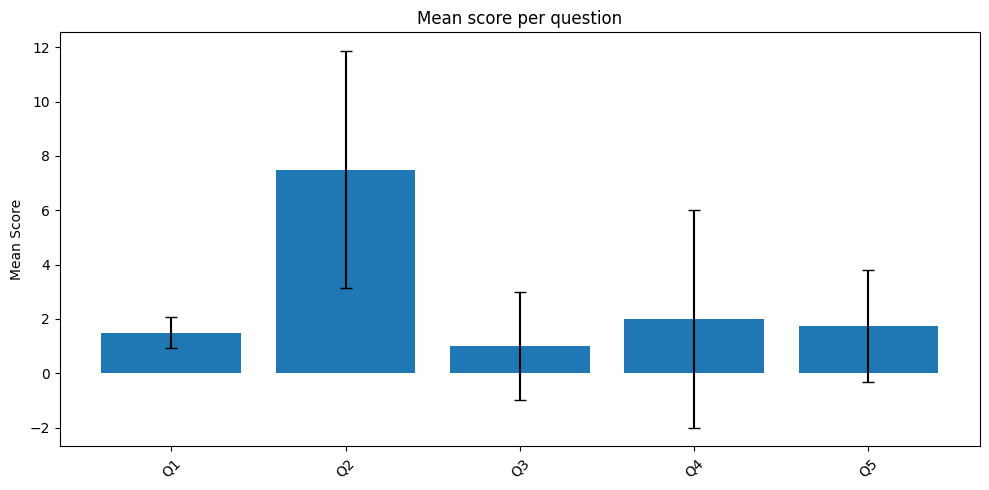

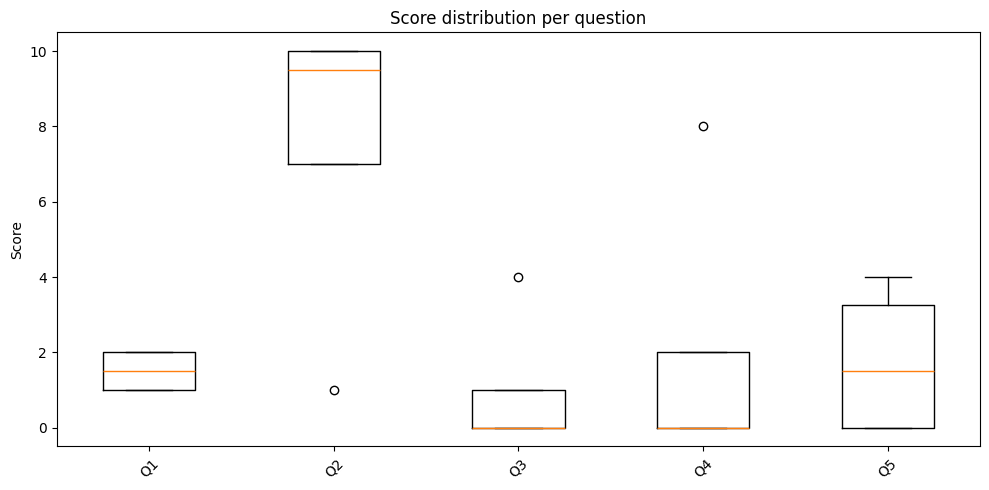

In [64]:
# Per-question metrics and charts
import os
import pandas as pd
import matplotlib.pyplot as plt

question_cols = [col for col in marksDf.columns if col not in ["ID", "NAME", "CLASS", "Marks"]]
stats_rows = []
for q in question_cols:
    s = pd.to_numeric(marksDf[q], errors="coerce")
    max_mark = None
    if "question_meta" in globals() and q in question_meta:
        max_mark = question_meta[q].get("marks")
    pass_cutoff_q = None
    if max_mark is not None and pd.notna(max_mark):
        pass_cutoff_q = 0.5 * max_mark
    pass_rate_q = None
    if pass_cutoff_q is not None:
        pass_rate_q = (s >= pass_cutoff_q).mean() * 100 if len(s.dropna()) else None
    stats_rows.append({
        "Question": q,
        "Mean": s.mean(),
        "Median": s.median(),
        "StdDev": s.std(),
        "Min": s.min(),
        "Max": s.max(),
        "NonNull": s.notna().sum(),
        "Pass Cutoff": pass_cutoff_q,
        "Pass Rate (%)": pass_rate_q,
    })

question_stats_df = pd.DataFrame(stats_rows)
display(question_stats_df)

# Persist question metrics to Excel
if details_report_path:
    excel_kwargs = {
        "mode": "a" if os.path.exists(details_report_path) else "w",
        "engine": "openpyxl" if os.path.exists(details_report_path) else None,
        "if_sheet_exists": "replace" if os.path.exists(details_report_path) else None,
    }
    with pd.ExcelWriter(details_report_path, **excel_kwargs) as writer:
        question_stats_df.to_excel(writer, sheet_name="QuestionMetrics", index=False)
    print("Saved QuestionMetrics sheet in:", details_report_path)

# Charts: mean per question (with std as error bars) and score distribution
plt.figure(figsize=(10, 5))
plt.bar(question_stats_df["Question"], question_stats_df["Mean"], yerr=question_stats_df["StdDev"], capsize=4)
plt.ylabel("Mean Score")
plt.title("Mean score per question")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot([pd.to_numeric(marksDf[q], errors="coerce").dropna() for q in question_cols], labels=question_cols)
plt.ylabel("Score")
plt.title("Score distribution per question")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [69]:
# Export class overview to a Word report with markdown-aware formatting
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt, Inches

import re
import os
import matplotlib.pyplot as plt

if "class_overview_report" not in globals():
    raise RuntimeError("Run the class overview cell first to populate class_overview_report and class_overview_df.")

# Ensure per-question stats are available
if "question_stats_df" not in globals():
    question_cols = [col for col in marksDf.columns if col not in ["ID", "NAME", "CLASS", "Marks"]]
    stats_rows = []
    for q in question_cols:
        s = pd.to_numeric(marksDf[q], errors="coerce")
        max_mark = None
        if "question_meta" in globals() and q in question_meta:
            max_mark = question_meta[q].get("marks")
        pass_cutoff_q = None
        if max_mark is not None and pd.notna(max_mark):
            pass_cutoff_q = 0.5 * max_mark
        pass_rate_q = None
        if pass_cutoff_q is not None:
            pass_rate_q = (s >= pass_cutoff_q).mean() * 100 if len(s.dropna()) else None
        stats_rows.append({
            "Question": q,
            "Mean": s.mean(),
            "Median": s.median(),
            "StdDev": s.std(),
            "Min": s.min(),
            "Max": s.max(),
            "NonNull": s.notna().sum(),
            "Pass Cutoff": pass_cutoff_q,
            "Pass Rate (%)": pass_rate_q,
        })
    question_stats_df = pd.DataFrame(stats_rows)

word_path = os.path.join(base_path_marked_scripts, "class_overview_report.docx")
charts_dir = os.path.join(base_path_marked_scripts, "charts")
os.makedirs(charts_dir, exist_ok=True)
doc = Document()

# Base styles
doc.styles["Normal"].font.size = Pt(11)

title_text = "Class Performance Overview"
if "prefix" in globals() and prefix:
    title_text = f"{prefix} - {title_text}"
doc.add_heading(title_text, level=1)

# Key stats summary line
summary_line = (
    f"Students: {len(marksDf)} | Mean: {mean_score:.2f} | Median: {median_score:.2f} | "
    f"Pass rate: {pass_rate:.1f}% (cutoff {passing_cutoff})"
 )
doc.add_paragraph(summary_line)

def add_markdown_line(md_line, bullet=False, heading_level=None):
    """Render a single markdown line into the docx with bold/italic support."""
    if heading_level:
        p = doc.add_heading(level=heading_level)
    elif bullet:
        p = doc.add_paragraph(style="List Bullet")
    else:
        p = doc.add_paragraph()

    tokens = re.split(r"(\*\*[^*]+\*\*|__[^_]+__|\*[^*]+\*|_[^_]+_)", md_line)
    for tok in tokens:
        if not tok:
            continue
        bold = tok.startswith("**") or tok.startswith("__")
        italic = tok.startswith("*") or tok.startswith("_")
        clean = tok.strip("*_ ")
        run = p.add_run(clean)
        if bold:
            run.bold = True
        if italic:
            run.italic = True
    return p

# Gemini narrative with markdown preserved (placed before metrics)
if class_overview_report:
    doc.add_heading("Narrative Summary", level=2)
    for raw_line in class_overview_report.splitlines():
        line = raw_line.rstrip()
        if not line:
            continue
        heading_match = re.match(r"^(#{1,3})\s+(.*)$", line)
        if heading_match:
            level = len(heading_match.group(1))
            add_markdown_line(heading_match.group(2), heading_level=level)
            continue
        if re.match(r"^[-*+]\s+", line):
            add_markdown_line(line[2:].strip(), bullet=True)
            continue
        num_match = re.match(r"^\d+\.\s+(.*)$", line)
        if num_match:
            p = add_markdown_line(num_match.group(1))
            p.style = "List Number"
            continue
        p = add_markdown_line(line)
        p.alignment = WD_ALIGN_PARAGRAPH.LEFT

# Class-level charts
overall_hist = os.path.join(charts_dir, "overall_hist.png")
pass_bar = os.path.join(charts_dir, "pass_bar.png")
plt.figure(figsize=(8, 4))
plt.hist(pd.to_numeric(marksDf["Marks"], errors="coerce").dropna(), bins=20, color="#4a90e2")
plt.xlabel("Total Score")
plt.ylabel("Students")
plt.title("Score distribution (class)")
plt.tight_layout()
plt.savefig(overall_hist, dpi=180)
plt.close()
plt.figure(figsize=(6, 4))
fail_count = len(marksDf) - pass_count if "pass_count" in globals() else None
plt.bar(["Pass", "Fail"], [pass_count if "pass_count" in globals() else 0, fail_count if fail_count is not None else 0], color=["#4caf50", "#e74c3c"])
plt.ylabel("Students")
plt.title("Pass / Fail counts")
plt.tight_layout()
plt.savefig(pass_bar, dpi=180)
plt.close()
doc.add_page_break()
doc.add_heading("Class Charts", level=2)
doc.add_paragraph("Score histogram shows the spread of total scores; bars to the right indicate higher-performing students.")
doc.add_picture(overall_hist, width=Inches(6))
doc.add_paragraph("Pass/Fail bars show how many students met the passing cutoff versus those below it.")
doc.add_picture(pass_bar, width=Inches(4))

# Metrics table (omit the overview narrative row if present)
if "class_overview_df" in globals():
    table_df = class_overview_df.copy()
    table_df = table_df[table_df["Metric"] != "Gemini Class Overview"]
    if not table_df.empty:
        doc.add_page_break()
        doc.add_heading("Metrics", level=2)
        table = doc.add_table(rows=1, cols=2, style="Light Grid")
        hdr_cells = table.rows[0].cells
        hdr_cells[0].text = "Metric"
        hdr_cells[1].text = "Value"
        for _, row in table_df.iterrows():
            cells = table.add_row().cells
            cells[0].text = str(row["Metric"])
            cells[1].text = str(row["Value"])

# Per-question metrics table
if "question_stats_df" in globals() and not question_stats_df.empty:
    doc.add_page_break()
    doc.add_heading("Per-Question Metrics", level=2)
    pq_table = doc.add_table(rows=1, cols=6, style="Light Grid")
    hdr = pq_table.rows[0].cells
    hdr[0].text = "Question"
    hdr[1].text = "Mean"
    hdr[2].text = "Median"
    hdr[3].text = "StdDev"
    hdr[4].text = "Min / Max"
    hdr[5].text = "Pass Rate (%)"
    for _, r in question_stats_df.iterrows():
        cells = pq_table.add_row().cells
        cells[0].text = str(r.get("Question", ""))
        cells[1].text = f"{r['Mean']:.2f}" if pd.notna(r.get("Mean")) else ""
        cells[2].text = f"{r['Median']:.2f}" if pd.notna(r.get("Median")) else ""
        cells[3].text = f"{r['StdDev']:.2f}" if pd.notna(r.get("StdDev")) else ""
        min_val = f"{r['Min']:.2f}" if pd.notna(r.get("Min")) else ""
        max_val = f"{r['Max']:.2f}" if pd.notna(r.get("Max")) else ""
        cells[4].text = f"{min_val} / {max_val}" if (min_val or max_val) else ""
        cells[5].text = f"{r['Pass Rate (%)']:.1f}" if pd.notna(r.get("Pass Rate (%)")) else ""

    # Charts saved to disk then embedded
    mean_chart = os.path.join(charts_dir, "question_mean.png")
    box_chart = os.path.join(charts_dir, "question_box.png")
    pass_rate_chart = os.path.join(charts_dir, "question_pass_rate.png")
    plt.figure(figsize=(10, 5))
    plt.bar(question_stats_df["Question"], question_stats_df["Mean"], yerr=question_stats_df["StdDev"], capsize=4)
    plt.ylabel("Mean Score")
    plt.title("Mean score per question")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(mean_chart, dpi=180)
    plt.close()
    plt.figure(figsize=(10, 5))
    plt.boxplot([pd.to_numeric(marksDf[q], errors="coerce").dropna() for q in question_stats_df["Question"]], labels=question_stats_df["Question"])
    plt.ylabel("Score")
    plt.title("Score distribution per question")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(box_chart, dpi=180)
    plt.close()
    plt.figure(figsize=(10, 5))
    plt.bar(question_stats_df["Question"], question_stats_df["Pass Rate (%)"], color="#7b7ce6")
    plt.ylabel("Pass Rate (%)")
    plt.title("Pass rate per question")
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(pass_rate_chart, dpi=180)
    plt.close()
    doc.add_paragraph("Mean bars highlight which questions students scored higher on, with error bars showing variability.")
    doc.add_picture(mean_chart, width=Inches(6))
    doc.add_paragraph("Box plots show the spread of marks per question (median, quartiles, and outliers).")
    doc.add_picture(box_chart, width=Inches(6))
    doc.add_paragraph("Pass-rate bars show what percent of students reached at least half marks for each question.")
    doc.add_picture(pass_rate_chart, width=Inches(6))

# Strengths / focus questions (skip headings if empty)
has_strengths = "top_strengths" in globals() and hasattr(top_strengths, "empty") and not top_strengths.empty
has_focus = "top_focus" in globals() and hasattr(top_focus, "empty") and not top_focus.empty
if has_strengths:
    doc.add_heading("Top Strength Questions", level=2)
    for q, val in top_strengths.items():
        doc.add_paragraph(f"{q}: {val:.2f}", style="List Bullet")
if has_focus:
    doc.add_heading("Top Focus Questions", level=2)
    for q, val in top_focus.items():
        doc.add_paragraph(f"{q}: {val:.2f}", style="List Bullet")

# Sampled report count
if "sample_reports" in globals():
    foot = doc.add_paragraph()
    run = foot.add_run(f"Sampled individual reports included in prompt: {len(sample_reports)}")
    run.font.size = Pt(9)
    foot.alignment = WD_ALIGN_PARAGRAPH.LEFT

# Save
doc.save(word_path)
print("Saved Word report:", word_path)

Saved Word report: ../marking_form/VTC Test/marked/scripts/class_overview_report.docx


In [66]:
from IPython.display import FileLink 

# zip base_path_marked_scripts folder
script_zip = base_path_marked_scripts + "../scripts"
shutil.make_archive(script_zip, "zip", base_path_marked_scripts)
FileLink(script_zip + ".zip")

/workspaces/gemini-handwriting-grader/marking_form/VTC Test/marked/scripts.zip